# Examining problematic sulfonamide geometries

Molecules pulled from sage-2.2.0 repo.

In [1]:
from openff.toolkit.topology import Molecule, Topology
from openff.toolkit.typing.engines.smirnoff import ForceField
from openff.units import unit

from openff.interchange import Interchange
from openff.interchange.drivers import get_gromacs_energies, get_openmm_energies
import multiprocessing
import tqdm
import numpy as np
import sys
import openmm
from openff.units.openmm import from_openmm
import os
# suppress stereochemistry warnings
import logging
from rdkit import Chem
import itertools

from openff.qcsubmit.results import TorsionDriveResultCollection, OptimizationResultCollection
import logging
logging.getLogger("openff").setLevel(logging.ERROR)

from openff.qcsubmit.results.filters import SMARTSFilter

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolTransforms

import MDAnalysis as mda

In [2]:
def minimize_energy(mol,ff):
    topo = mol.to_topology()
    interchange = Interchange.from_smirnoff(force_field=ff, topology=topo,allow_nonintegral_charges=True)#,charge_from_molecules=[mol]) #,charge_from_molecules=[mol])
    integrator = openmm.VerletIntegrator(1 * openmm.unit.femtoseconds)
    simulation = interchange.to_openmm_simulation(integrator)

    # We'll store energies in two lists
    initial_energies = []
    minimized_energies = []

    # And minimized conformers in a second molecule
    minimized_molecule = Molecule.from_topology(topo)
    minimized_molecule.conformers.clear()

    conformer = mol.conformers[0]
    # Tell the OpenMM Simulation the positions of this conformer
    simulation.context.setPositions(conformer.to_openmm())

    # Keep a record of the initial energy
    initial_energies.append(
        simulation.context.getState(getEnergy=True).getPotentialEnergy()
    )

    # Perform the minimization
    simulation.minimizeEnergy()#tolerance=Quantity(value=0.0026255, unit=kilojoule/mole))#tolerance=5e-9)

    # Record minimized energy and positions
    min_state = simulation.context.getState(getEnergy=True, getPositions=True)

    minimized_energies.append(min_state.getPotentialEnergy())
    minimized_molecule.add_conformer(from_openmm(min_state.getPositions()))
    return initial_energies,minimized_energies,minimized_molecule


Choosing a few problem cases:

# Molecule 38, QCArchive ID 36973709
Bad with Sage 2.0.0 and 2.1, fixed in 2.2

In [72]:
# test_mol1 = industry_benchmark_rm[28][1]
# test_mol1

NGLWidget()

In [73]:
# test_mol1.to_file('qcaid_36973709.sdf',file_format='sdf')

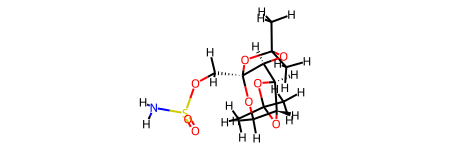

In [3]:
test_mol1 = Molecule.from_file('qcaid_36973709.sdf')
test_mol1.to_rdkit()

In [4]:
ie_sage200_qm1,me_sage200_qm1,min_mol_sage200_qm1 = minimize_energy(test_mol1,ForceField('openff_unconstrained-2.0.0.offxml'))

In [5]:
u_sage200_min = mda.Universe(min_mol_sage200_qm1.to_rdkit())
u_sage200_min.atoms.write("sage-200_qcaid_36973709_opt.pdb")

/Users/lily/micromamba/envs/yammbs/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:777: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
/Users/lily/micromamba/envs/yammbs/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/Users/lily/micromamba/envs/yammbs/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'resnames' Using default value of 'UNK'
  warnings.warn("Found no information for attr: '{}'"
/Users/lily/micromamba/envs/yammbs/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'icodes' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/Users/lily/micromamba/envs/yammbs/lib/python3.10/site-packag

In [8]:
ie_sage210_qm1,me_sage210_qm1,min_mol_sage210_qm1 = minimize_energy(test_mol1,ForceField('openff_unconstrained-2.1.0.offxml'))

In [38]:
u_sage210_min = mda.Universe(min_mol_sage210_qm1.to_rdkit())
u_sage210_min.atoms.write("sage-210_qcaid_36973709_opt.pdb")

In [13]:
ie_sage220_qm1,me_sage220_qm1,min_mol_sage220_qm1 = minimize_energy(test_mol1,ForceField('../../../openff_unconstrained-2.2.0.offxml',allow_cosmetic_attributes=True))

In [14]:
u_sage220_min = mda.Universe(min_mol_sage220_qm1.to_rdkit())
u_sage220_min.atoms.write("sage-220_qcaid_36973709_opt.pdb")

In [15]:
ie_sage221_qm1,me_sage221_qm1,min_mol_sage221_qm1 = minimize_energy(test_mol1,ForceField('../../../openff_unconstrained-2.2.1-rc1.offxml',allow_cosmetic_attributes=True))

In [16]:
u_sage221_min = mda.Universe(min_mol_sage221_qm1.to_rdkit())
u_sage221_min.atoms.write("sage-221_qcaid_36973709_opt.pdb")

In [39]:
u_qm_min = mda.Universe(test_mol1.to_rdkit())
u_qm_min.atoms.write("qm_qcaid_36973709_opt.pdb")

In [17]:
min_mol_sage221_qm1.to_file('qcaid_36973709_optsage221.sdf',file_format='sdf')

In [18]:
opt1_sage200 = min_mol_sage200_qm1.to_rdkit()
opt1_sage200_conf = opt1_sage200.GetConformer()

In [19]:
opt1_sage210 = min_mol_sage210_qm1.to_rdkit()
opt1_sage210_conf = opt1_sage210.GetConformer()

In [20]:
opt1_sage220 = min_mol_sage220_qm1.to_rdkit()
opt1_sage220_conf = opt1_sage220.GetConformer()

In [21]:
opt1_sage221 = min_mol_sage221_qm1.to_rdkit()
opt1_sage221_conf = opt1_sage221.GetConformer()

In [22]:
qm_rdkit1 = test_mol1.to_rdkit()
qm_conf1 = qm_rdkit1.GetConformer()

### Geometries

In [23]:
atoms1=[a for a in opt1_sage200.GetAtoms()]

In [24]:
atom_indices_s1 = [a.GetIdx() for a in atoms1 if a.GetSymbol() == 'S']

In [25]:
atom_indices_n1 = [a.GetIdx() for a in atoms1 if a.GetSymbol()=='N']

In [26]:
atom_indices_o1 = [a.GetIdx() for a in atoms1 if a.GetSymbol()=='O']

In [27]:
print(atom_indices_s1)
print(atom_indices_n1)
print(atom_indices_o1)

[18]
[21]
[3, 4, 7, 11, 14, 17, 19, 20]


In [28]:
s = atom_indices_s1[0]
n1 = atom_indices_n1[0]
o1,o2,o3 = atom_indices_o1[5:]

In [29]:
Chem.rdMolTransforms.GetBondLength(opt1_sage200_conf,s,n1) # N

1.6206560883798915

In [30]:
Chem.rdMolTransforms.GetBondLength(opt1_sage200_conf,s,o3) # N

1.4608956862017417

In [31]:
Chem.rdMolTransforms.GetBondLength(opt1_sage200_conf,s,o1) # O

1.6606910455089654

In [32]:
Chem.rdMolTransforms.GetBondLength(opt1_sage200_conf,s ,o2) # O

1.4644027359174516

In [33]:
print('N1 - S - N2:',Chem.rdMolTransforms.GetAngleDeg(opt1_sage200_conf,n1,s,o3)) # N1 - S - N2
print('N1 - S - O1:',Chem.rdMolTransforms.GetAngleDeg(opt1_sage200_conf,n1,s,o1)) # N1 - S - O1
print('N1 - S - O2:',Chem.rdMolTransforms.GetAngleDeg(opt1_sage200_conf,n1,s,o2)) # N1 - S - O2
print('O1 - S - O2:',Chem.rdMolTransforms.GetAngleDeg(opt1_sage200_conf,o1,s,o2)) # O1 - S - O2


N1 - S - N2: 98.2518601557458
N1 - S - O1: 98.72508050463759
N1 - S - O2: 98.66647197967072
O1 - S - O2: 117.57388639620558


In [34]:
print('N1 - S - N2:',Chem.rdMolTransforms.GetAngleDeg(opt1_sage210_conf,n1,s,o3)) # N1 - S - N2
print('N1 - S - O1:',Chem.rdMolTransforms.GetAngleDeg(opt1_sage210_conf,n1,s,o1)) # N1 - S - O1
print('N1 - S - O2:',Chem.rdMolTransforms.GetAngleDeg(opt1_sage210_conf,n1,s,o2)) # N1 - S - O2
print('O1 - S - O2:',Chem.rdMolTransforms.GetAngleDeg(opt1_sage210_conf,o1,s,o2)) # O1 - S - O2


N1 - S - N2: 87.52746498994652
N1 - S - O1: 99.96892732534184
N1 - S - O2: 88.96295700981113
O1 - S - O2: 117.14814115411868


In [35]:
print('N1 - S - N2:',Chem.rdMolTransforms.GetAngleDeg(opt1_sage220_conf,n1,s,o3)) # N1 - S - N2
print('N1 - S - O1:',Chem.rdMolTransforms.GetAngleDeg(opt1_sage220_conf,n1,s,o1)) # N1 - S - O1
print('N1 - S - O2:',Chem.rdMolTransforms.GetAngleDeg(opt1_sage220_conf,n1,s,o2)) # N1 - S - O2
print('O1 - S - O2:',Chem.rdMolTransforms.GetAngleDeg(opt1_sage220_conf,o1,s,o2)) # O1 - S - O2


N1 - S - N2: 99.09034514324298
N1 - S - O1: 105.32834997158153
N1 - S - O2: 101.61848376706394
O1 - S - O2: 111.40002546065031


In [37]:
print('N1 - S - N2:',Chem.rdMolTransforms.GetAngleDeg(opt1_sage221_conf,n1,s,o3)) # N1 - S - N2
print('N1 - S - O1:',Chem.rdMolTransforms.GetAngleDeg(opt1_sage221_conf,n1,s,o1)) # N1 - S - O1
print('N1 - S - O2:',Chem.rdMolTransforms.GetAngleDeg(opt1_sage221_conf,n1,s,o2)) # N1 - S - O2
print('O1 - S - O2:',Chem.rdMolTransforms.GetAngleDeg(opt1_sage221_conf,o1,s,o2)) # O1 - S - O2


N1 - S - N2: 99.08872900325532
N1 - S - O1: 105.42148791490503
N1 - S - O2: 100.95334120678255
O1 - S - O2: 111.43378965795716


In [36]:
print('N1 - S - N2:',Chem.rdMolTransforms.GetAngleDeg(qm_conf1,n1,s,o3)) # N1 - S - N2
print('N1 - S - O1:',Chem.rdMolTransforms.GetAngleDeg(qm_conf1,n1,s,o1)) # N1 - S - O1
print('N1 - S - O2:',Chem.rdMolTransforms.GetAngleDeg(qm_conf1,n1,s,o2)) # N1 - S - O2
print('O1 - S - O2:',Chem.rdMolTransforms.GetAngleDeg(qm_conf1,o1,s,o2)) # O1 - S - O2

N1 - S - N2: 106.32336151064213
N1 - S - O1: 96.99080933223917
N1 - S - O2: 111.58979989778157
O1 - S - O2: 107.38300244083004
